In [ ]:
!pip install av transformers huggingface_hub torch numpy music21 midi2audio einops -q
!pip install opencv-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import av
import torch
import numpy as np
from transformers import AutoProcessor, AutoModel, VideoMAEModel, VideoMAEImageProcessor, VideoMAEConfig
from huggingface_hub import hf_hub_download
import cv2
from music21 import note, scale, stream
from music21 import stream, chord, note, roman, scale
import random
from music21 import midi

# np.random.seed(0)

In [ ]:
def read_video_pyav(container, indices):
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

In [ ]:
file_path = "/content/drive/MyDrive/Video2Music/sunset.mp4"
container = av.open(file_path)

# sample 8 frames
indices = sample_frame_indices(clip_len=16, frame_sample_rate=8, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
model = AutoModel.from_pretrained("microsoft/xclip-base-patch32-16-frames")
model.to(device)

classes = [
    "dominant colour of this video is red",  # C
    "dominant colour of this video is orange-pink",  # G
    "dominant colour of this video is yellow",  # D
    "dominant colour of this video is green",  # A
    "dominant colour of this video is whitish-blue",  # E
    "dominant colour of this video is blue",  # B
    "dominant colour of this video is blue, bright",  # F♯
    "dominant colour of this video is violet",  # D♭
    "dominant colour of this video is purplish-violet",  # A♭
    "dominant colour of this video is steel colour with metallic sheen",  # E♭
    "dominant colour of this video is Rosé",  # B♭
    "dominant colour of this video is red, dark"  # F
]

chord_map = {
    "dominant colour of this video is red": "C",
    "dominant colour of this video is orange-pink": "G",
    "dominant colour of this video is yellow": "D",
    "dominant colour of this video is green": "A",
    "dominant colour of this video is whitish-blue": "E",
    "dominant colour of this video is blue": "B",
    "dominant colour of this video is blue, bright": "F#",
    "dominant colour of this video is violet": "D-",
    "dominant colour of this video is purplish-violet": "A-",
    "dominant colour of this video is steel colour with metallic sheen": "E-",
    "dominant colour of this video is Rosé": "B-",
    "dominant colour of this video is red, dark": "F"
}

inputs = processor(
    text=classes,
    videos=list(video),
    padding=True,
    return_tensors="pt",
)

inputs = {
    'input_ids': inputs['input_ids'].to(device),
    'attention_mask': inputs['attention_mask'].to(device),
    'pixel_values': inputs['pixel_values'].to(device)
}

# forward pass
with torch.no_grad():
    outputs = model(**inputs)
    logits_per_video = outputs.logits_per_video

probs = logits_per_video.softmax(dim=1)
print("Probabilities:")
for i in range(len(classes)):
    print(f"{classes[i]}: {probs[0][i]:.4f}")

# Get the class with the highest probability
classified_class = classes[probs.argmax().item()]

# Get the corresponding chord for the classified class
classified_note = chord_map[classified_class]

print(f"\nClassified note: {classified_note}, Dominant color: {classified_class} ")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/8.90k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/787M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)


Probabilities:
dominant colour of this video is red: 0.0609
dominant colour of this video is orange-pink: 0.2183
dominant colour of this video is yellow: 0.0674
dominant colour of this video is green: 0.0739
dominant colour of this video is whitish-blue: 0.0745
dominant colour of this video is blue: 0.1120
dominant colour of this video is blue, bright: 0.1152
dominant colour of this video is violet: 0.0191
dominant colour of this video is purplish-violet: 0.0124
dominant colour of this video is steel colour with metallic sheen: 0.0463
dominant colour of this video is Rosé: 0.0333
dominant colour of this video is red, dark: 0.1668

Classified note: G, Dominant color: dominant colour of this video is orange-pink 


In [ ]:
indices

array([142, 150, 159, 167, 176, 184, 193, 201, 210, 218, 227, 235, 244,
       252, 261, 269])

In [ ]:
def generate_music(classified_note, duration: int = 60) -> None:
    scale_type = scale.MajorScale(classified_note + '4')
    notes = []
    for _ in range(duration):
        # 처음에 해당하는 스케일의 note가 나오도록 수정(Idea)
        degree = np.random.randint(1, 8)
        pitch = scale_type.pitchFromDegree(degree)
        new_note = note.Note(pitch.nameWithOctave)
        notes.append(new_note)

    music = stream.Stream(notes)
    music.write('midi', fp='/content/drive/MyDrive/Video2Music/midi_output/output.mid')

generate_music(classified_note)

In [ ]:
def generate_music_with_first_scale(classified_note, duration: int = 60) -> None:
    scale_type = scale.MajorScale(classified_note + '4')
    notes = []

    # 첫 음을 해당 스케일의 1도(으뜸음)로 설정
    pitch = scale_type.pitchFromDegree(1)
    first_note = note.Note(pitch.nameWithOctave)
    notes.append(first_note)

    for _ in range(duration - 1):
        degree = np.random.randint(1, 8)
        pitch = scale_type.pitchFromDegree(degree)
        new_note = note.Note(pitch.nameWithOctave)
        notes.append(new_note)

    music = stream.Stream(notes)
    music.write('midi', fp='/content/drive/MyDrive/Video2Music/midi_output/output_with_first_scale.mid')

generate_music_with_first_scale(classified_note)

In [ ]:
def generate_music_with_chords_progression(key, duration: int = 60) -> None:
    s = stream.Stream()
    chord_progression = ['I', 'V', 'vi', 'IV']

    for _ in range(duration // len(chord_progression)):
        for numeral in chord_progression:
            rn = roman.RomanNumeral(numeral, key)
            c = chord.Chord(rn.pitches)
            c.duration.quarterLength = 1
            s.append(c)

    s.write('midi', fp='/content/drive/MyDrive/Video2Music/midi_output/output_with_chords_progression.mid')

generate_music_with_chords_progression(classified_note)

In [ ]:
def generate_music_with_chords_progression_and_randomness(key, duration: int = 60) -> None:
    s = stream.Stream()
    chord_progression = ['I', 'V', 'vi', 'IV']
    durations = [0.25, 0.5, 1]  # 16분 음표, 8분 음표, 4분 음표

    for _ in range(duration // len(chord_progression)):
        for numeral in chord_progression:
            rn = roman.RomanNumeral(numeral, key)
            # 화음 내에서 무작위 음 선택
            pitches = random.sample(rn.pitches, k=random.randint(1, len(rn.pitches)))
            for pitch in pitches:
                n = note.Note(pitch)
                n.duration.quarterLength = random.choice(durations)
                s.append(n)

    s.write('midi', fp='/content/drive/MyDrive/Video2Music/midi_output/output_with_randomness.mid')

generate_music_with_chords_progression_and_randomness(classified_note)

In [ ]:
def play_midi_file(midi_file_path: str) -> None:
    mf = midi.MidiFile()
    mf.open(midi_file_path)
    mf.read()
    mf.close()
    midi_stream = midi.translate.midiFileToStream(mf)
    midi_stream.show('midi')

play_midi_file('/content/drive/MyDrive/Video2Music/midi_output/output.mid')

In [ ]:
play_midi_file('/content/drive/MyDrive/Video2Music/midi_output/output_with_first_scale.mid')

In [ ]:
play_midi_file('/content/drive/MyDrive/Video2Music/midi_output/output_with_chords_progression.mid')

In [ ]:
play_midi_file('/content/drive/MyDrive/Video2Music/midi_output/output_with_randomness.mid')

In [ ]:
!apt-get install fluidsynth -y -q

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0
  libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-imag

In [ ]:
!pip install midi2audio
from midi2audio import FluidSynth

def convert_midi_to_wav(midi_file: str, wav_file: str, sound_font: str) -> None:
    fs = FluidSynth(sound_font)
    fs.midi_to_audio(midi_file, wav_file)

midi_file = "/content/drive/MyDrive/Video2Music/midi_output/output.mid"
wav_file = "/content/drive/MyDrive/Video2Music/wav_output/output.wav"
sound_font = "/content/drive/MyDrive/Video2Music/GeneralUser GS 1.471/GeneralUser GS v1.471.sf2"

convert_midi_to_wav(midi_file, wav_file, sound_font)
print("Conversion complete!")

Conversion complete!


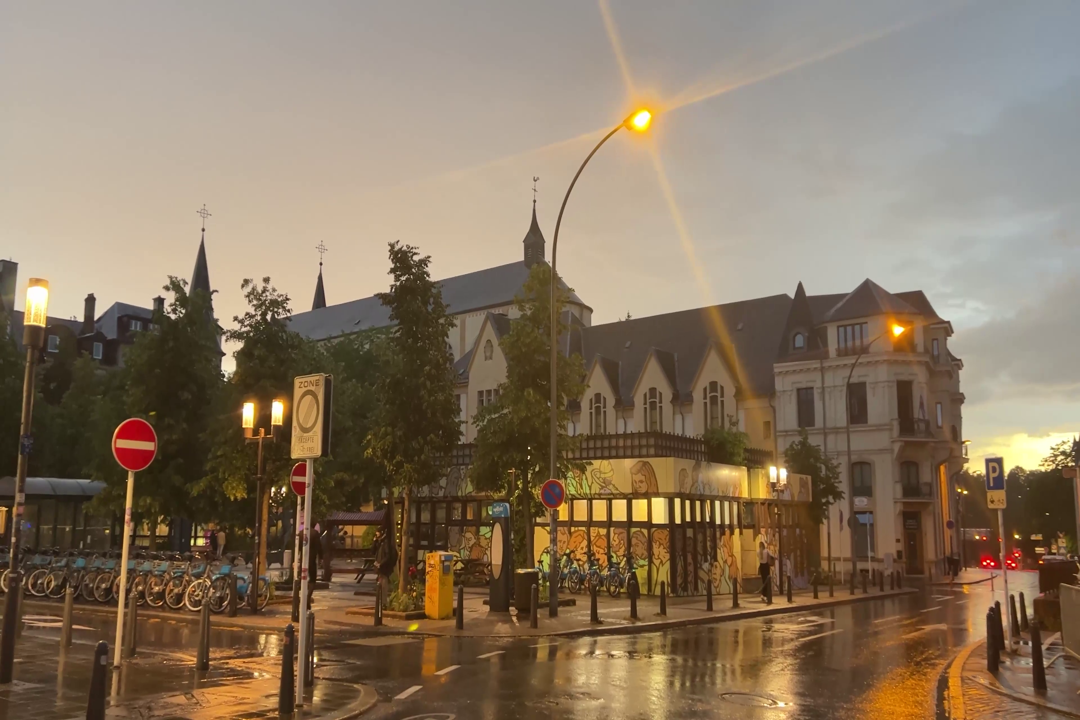

In [ ]:
from PIL import Image

random_frame_index = np.random.choice(indices)
frame = video[np.where(indices == random_frame_index)[0][0]]
frame_image = Image.fromarray(frame)
frame_image = frame_image.resize((1080, 720))
frame_image

In [ ]:
#video captioning

from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import torch

model_id = "vikhyatk/moondream2"
revision = "2024-04-02"

caption_model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True, revision=revision
)
tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
caption_model.to(device)

print(" ")

config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

configuration_moondream.py:   0%|          | 0.00/3.39k [00:00<?, ?B/s]

moondream.py:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

vision_encoder.py:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/49.4k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
device

'cuda:0'

In [ ]:
enc_image = caption_model.encode_image(frame_image).to(device)

# describe_text = caption_model.answer_question(enc_image, "Very briefly summarize the overall feel of this photo.", tokenizer)
describe_text = caption_model.answer_question(enc_image, "Describe the overall feel of this photo as detailed as possible.", tokenizer)

print(describe_text)

The image captures a rainy city street at dusk, with a large building featuring a clock tower in the background. The street is wet, reflecting the soft glow of the streetlights and the city lights. Several bicycles are parked along the sidewalk, and a few people can be seen walking on the sidewalk.

There are also a few cars parked on the street, and a traffic light is visible in the scene. The overall atmosphere of the image is one of a typical city street at dusk, with the rain adding a sense of calm and tranquility to the scene.


In [ ]:
import gc

# clean memory
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import json

file_name = file_path.split('/')[-1].split('.')[0]
generation_dict = {
    'file_name': file_name,
    'classified_note': classified_note,
    'describe_text': describe_text
}

# save JSON
with open(f"/content/drive/MyDrive/Video2Music/{file_name}_generation_info.json", "w") as outfile:
    json.dump(generation_dict, outfile)